# "Modulo 1"
> "Analisi Monte-Carlo della termodinamica di network random"

In questa relazione mi occuperò di studiare la termodinamica di un sistema tipo Ising, ma con interazioni a lunga distanza tra elementi casuali del network. 

Per farlo inizieremo prima dalla implementazione di un modello di Ising 2D classico per poi generalizzarlo e applicarlo al caso di interesse.

Lo studio sarà fatto attraverso un'analisi Monte-Carlo: una famiglia di metodi computazionali basati sul campionamento random delle possibili realizzazioni del sistema, che sono pesate da una distribuzione di probabilità da cui dipende il modello trattato. Attraverso questo campionamento casuale si cerca di esplorare tutto lo spazio delle configurazioni per poi andare a calcolare le osservabili di interesse sul campione finale. L'algoritmo Monte-Carlo utilizzato si basa su una catena di Markov, che si ottiene estraendo le varie configurazioni attraverso la distribuzione di Boltzmann.

Esistono vari algoritmi che soddisfano le condizioni richieste dai metodi Monte-Carlo, uno dei più usati, che è stato usato anche per lo studio dei sistemi in questa relazione, è il cosiddetto algoritmo Metropolis. L'implementazione richiederebbe l'uso di un generatore di numeri random, ma nella pratica vengono utilizzate routine che producono numeri detti pseudo-random attraverso algoritmi che garantiscono, entro certi limiti, numeri scorrelati tra loro con una distribuzione uniforme.

Un esempio di **generatore di numeri pseudo-random** è riportato nel codice sottostante, che rientra nella categoria dei cosiddetti *generatori congruenti lineari*, ovvero dove partendo da un certo valore $x_0$ la successione dei numeri pseudo casuali viene generata attraverso:
$$X_{i+1}=mod(aX_i+c,m)$$
Per certi valori dei parametri è dimostrato che questa successione si comporta piuttosto bene come generatore, in questo caso sono stati utilizzati:
$$a=16807, \quad c=0, \quad m=2^{31}-1$$


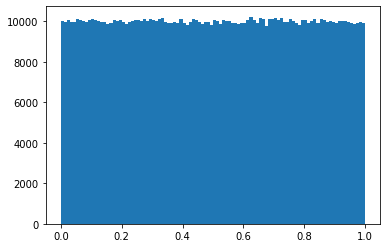

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from math import *

def rando(N,x0,ini,fin):
    x=np.zeros((N+2))
    a=16807   
    c=0     
    e=31      
    m=2**e-1

    x[0]=x0   # initial value

    for i in range(N+1):
        x[i+1]=(a*x[i]+c)%m
        
    return x[2:]/m*(fin-ini) + ini

x=rando(1000000,101,0,1)

plt.hist(x,100,rwidth=1)
plt.show()

Come si può notare dall'istogramma precedente la distribuzione dei valori risulta piuttosto uniforme per un gran numero di estrazioni, condizione necessaria, ma comunque non sufficiente a dimostrare che si tratti di un buon generatore.

Nel codice seguente però è stato utilizzato un generatore di numeri pseudo-random presente all'interno della libreria NumPy, poichè risulta più sicuro e più facile da implementare.

## Algoritmo Metropolis

Tra tutte le implementazioni che soddisfano alcune condizioni necessarie per il corretto funzionamento del Monte-Carlo, come quella di equilibrio, e altre condizioni utili seppur non necessarie, come il bilancio dettagliato, una classe di algoritmi tra i più efficienti è Metropolis. Per descrivere il funzionamento del Metropolis è necessario descrivere il processo stocastico che permette di passare da uno stato $a$ ad uno stato $b$ in un passo elementare della catena, ovvero bisogna definire la probabilità della transizione. Detta $p_i$ la probabilità di realizzazione della configurazione $i$, l'algoritmo si può articolare come segue:

* A partire dallo stato di partenza $a$ si seleziona uno stato $\tilde{b}$ a partire da una probabilità di transizione di prova
* Se risulta che $p_{\tilde{b}}>p_a$ allora si accetta $\tilde{b}$ come stato successivo $b$
* Se invece $p_{\tilde{b}}<p_a$ allora si accetta $b=\tilde{b}$ con probabilità $p_{\tilde{b}}/p_a$, e $a=\tilde{b}=b$ altrimenti.



In [124]:
#collapse
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.sparse as ss

Per l'implementazione dell'algoritmo sono state create alcune funzioni:
* Una che definisce lo stato iniziale: dato il numero di siti fornisce uno stato "caldo" con gli spin scelti tutti casualmente o "freddo" con gli spin tutti orientati nella stessa direzione, o +1 o -1

In [29]:
#collapse
def initialstate(L, random=True, cold=+1):
    if random:
        state = 2*np.random.randint(2, size=L)-1
    elif cold==1:
        state = np.int_(np.ones(L))
    elif cold==-1:
        state = -np.int_(np.ones(L))
    else:
        return print("Put cold = +1 or -1")
    return state

* Il passo del Metropolis è implementato dalla funzione "mcmove", che prende in input la configurazione precedente, il valore di $\beta$, ovvero l'inverso della temperatura, e la matrice di adiacenza del sistema considerato. La funzione restituisce la configurazione scelta attraverso il Metropolis.

In [30]:
#collapse
def mcmove(config, beta, A):
    "Monte Carlo move using Metropolis algorithm"
    con=config.copy()
    N=con.size
    for i in range(N):
        a = np.random.randint(0, N)
        s =  con[a]
        cost=sum(-(s*A[a])*con)-sum((s*A[a])*con)
        if -cost < 0:
            s = -s
        elif np.random.rand() < np.exp(cost*beta):
            s = -s
        con[a] = s
    return con

* Le seguenti funzioni calcolano rispettivamente l'energia e la magnetizzazione della configurazione di spin in input.

In [31]:
#collapse
def calcEnergy(config):
    "Energy of a given configuration"
    energy = 0
    for i in range(len(config)):
        S = config[i]
        energy += sum(-S*A[i]*config)
    return energy/config.size/4

def calcMag(config):
    "Magnetization of a given configuration"
    mag = np.sum(config)
    return mag/N


* La funzione che restituisce la matrice di adiacenza di un reticolo intero d-dimensionale con L elementi per lato

In [32]:
#collapse
def AdD(d,L):
    # This function returns the sparse adjacency matrix of a d-dimensonal  
        # integer lattice with side L and the total number of elements N=L**d
    # Only for Periodic Boundary Conditions
    
    import scipy.sparse as ss
    N=L**d
    A=ss.dok_matrix((N,N))
    for i in range(N):
        for j in range(d):
            A[i,(i+L**j)%N] = 1
            A[i,(i-L**j)%N] = 1
    return A.copy(), N

* La funzione che restituisce la suscettività magnetica o il calore specifico.

In [84]:
#collapse
def Di(m):
    return (np.mean(m*m)-np.mean(m)**2)

* La funzione che restituisce la varianza relativa alle grandezze calcolate con la funzione precedente, calcolata attraverso il metodo del Bootstrap.

In [131]:
#collapse
def bootd2(v,M,MM):
    rng = np.random.default_rng()
    N=len(v)
    MM=1
    y=np.zeros((M,N))
    
    for i in range(M):
        nr=rng.integers((N-MM), size=N//MM)
        
        for j in range(0,N//MM):
            y[i,j:j+MM]=v[int(nr[j]):int(nr[j])+MM]
    
    FF=np.zeros(M)
    for i in range(M):
        FF[i]=Di(y[i])/MM


    varia=0
    med1=0
    med2=0
    for i in range(M):
        med1+=FF[i]**2
        med2+=FF[i]
    med1=med1/M

    varia=med1-(med2/M)**2
    var=np.sqrt(varia)    
    
    return var

blablabla

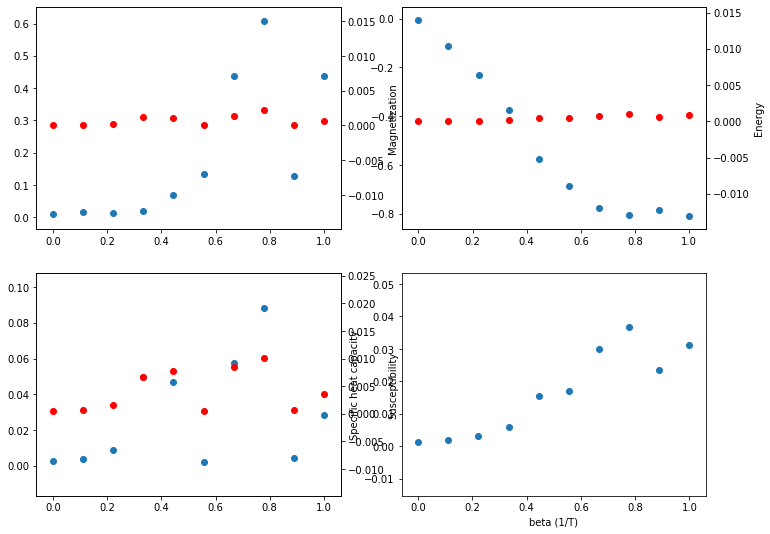

In [123]:
#collapse
meas=40
dec=10
tmin=0
tmax=1
tn=10
t=0
ma=np.zeros(tn)
msig=np.zeros(tn)
en=np.zeros(tn)
esig=np.zeros(tn)
xi=np.zeros(tn)
varx=np.zeros(tn)
cs=np.zeros(tn)
mm=0
ee=0
A=AdD(2,20)[0]
N=AdD(2,20)[1]

tempe=np.linspace(tmin,tmax,tn)

for it in tempe:

    state=np.ones((meas,N))
    state[0]=initialstate(N,random=True)
    #state[0]=np.ones(N)
    e=np.zeros(meas)
    m=np.zeros(meas)
    m[0]=calcMag(state[0])

    for i in range(meas-1):       # misure
        
        for j in range(dec):      # decorrelazione
            
            state[i+1]=mcmove(state[i], it, A).copy()
            
        m[i+1]=calcMag(state[i+1])
        e[i+1]=calcEnergy(state[i+1])
        
    m=m[meas//10:]
    ma[t]=sum(m)/meas
    msig[t]=sum((m-ma[t])**2)/(meas*(meas-1))
    en[t]=sum(e)/meas
    esig[t]=sum((e-en[t])**2)/(meas*(meas-1))
    xi[t]=Xi(m)
    cs[t]=Xi(e)
    varx[t]=bootd2(m,20,1)
    
    t+=1


plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.scatter(tempe,abs(ma))
plt.twinx()
plt.scatter(tempe,msig,color="r")
plt.xlabel('beta (1/T)')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.scatter(tempe,en)
plt.twinx()
plt.scatter(tempe,esig,color="r")
plt.xlabel('beta (1/T)')
plt.ylabel('Energy')

plt.subplot(223)
plt.scatter(tempe,(xi))
plt.twinx()
plt.scatter(tempe,varx,color="r")
plt.xlabel('beta (1/T)')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.scatter(tempe,(cs))
plt.xlabel('beta (1/T)')
plt.ylabel('Specific heat capacity')


plt.show()

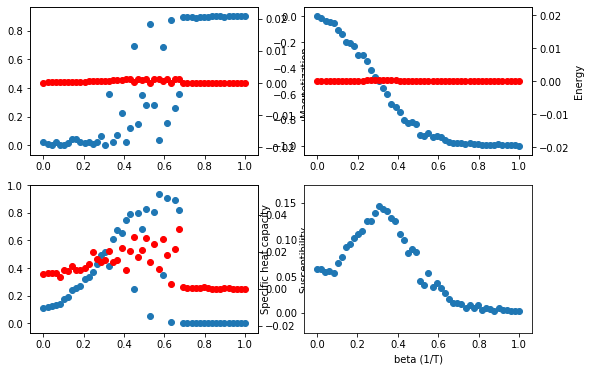

In [121]:
plt.figure(figsize=(9, 6))

plt.subplot(221)
plt.scatter(tempe,abs(ma))
plt.twinx()
plt.scatter(tempe,msig,color="r")
plt.xlabel('beta (1/T)')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.scatter(tempe,en)
plt.twinx()
plt.scatter(tempe,esig,color="r")
plt.xlabel('beta (1/T)')
plt.ylabel('Energy')

plt.subplot(223)
plt.scatter(tempe,(xi))
plt.twinx()
plt.scatter(tempe,varx,color="r")
plt.xlabel('beta (1/T)')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.scatter(tempe,(cs))
plt.xlabel('beta (1/T)')
plt.ylabel('Specific heat capacity')


plt.show()

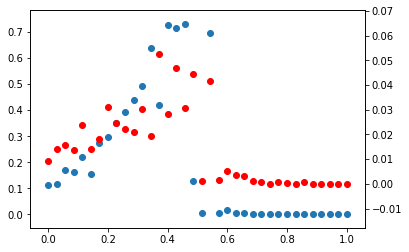

In [119]:
plt.scatter(tempe,(xi))
plt.twinx()
plt.scatter(tempe,varx,color="r")

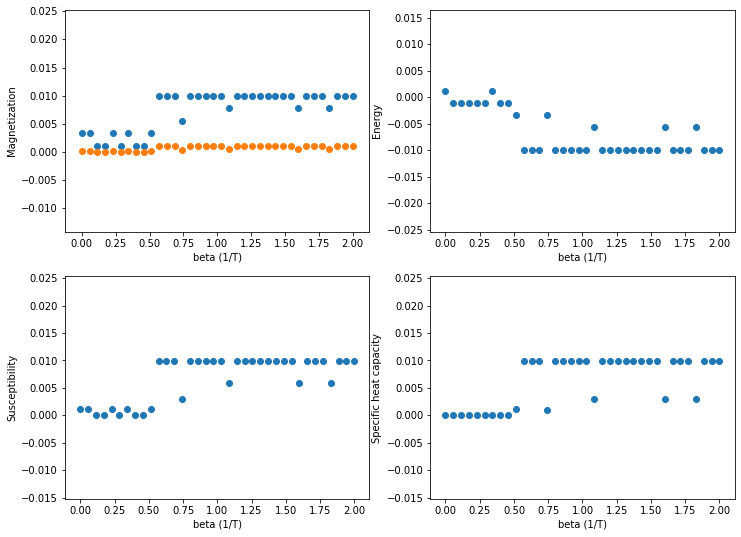

In [62]:
meas=100
dec=20
tmin=0
tmax=2
tn=36
t=0
ma=np.zeros(tn)
msig=np.zeros(tn)
en=np.zeros(tn)
xi=np.zeros(tn)
cs=np.zeros(tn)
ma2=np.zeros(tn)
en2=np.zeros(tn)
m2=np.zeros(meas)
e2=np.zeros(meas)
mm=0
ee=0
A=AdD(2,3)[0]
N=AdD(2,3)[1]

tempe=np.linspace(tmin,tmax,tn)

for it in tempe:

    state=np.ones((meas,N))
    state[0]=initialstate(N,random=True)
    #state[0]=np.ones(N)
    e=np.zeros(meas)
    m=np.zeros(meas)
    m[0]=calcMag(state[0])

    for i in range(dec):       # misure
        state[i+1]=mcmove(state[i], it, A-ss.rand(9,9,0.3)).copy()
    for j in range(meas-1):      # decorrelazione
        #print(str(i)+": "+str(state))
        state[i+1]=mcmove(state[i], it, A-ss.rand(9,9,0.3)).copy()
        m[i+1]=calcMag(state[i+1])
        e[i+1]=calcEnergy(state[i+1])
        m2[i+1]=m[i+1]*m[i+1]
        e2[i+1]=e[i+1]*e[i+1]
    m=m[meas//10:]
    ma[t]=sum(m)/meas
    msig[t]=sum((m-ma[t])**2)/(meas*(meas-1))
    ma2[t]=sum(m2)/meas
    en[t]=sum(e)/meas
    en2[t]=sum(e2)/meas
    xi[t]=ma2[t]-ma[t-1]**2
    cs[t]=en2[t]-en[t-1]**2
    
    t+=1



plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.scatter(tempe,abs(ma))
plt.scatter(tempe,msig*10)
plt.xlabel('beta (1/T)')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.scatter(tempe,en)
#plt.ylim(-1,1)
plt.xlabel('beta (1/T)')
plt.ylabel('Energy')

plt.subplot(223)
plt.scatter(tempe,(xi))
plt.xlabel('beta (1/T)')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.scatter(tempe,(cs))
plt.xlabel('beta (1/T)')
plt.ylabel('Specific heat capacity')


plt.show()

In [ ]:
def boot(m,N)

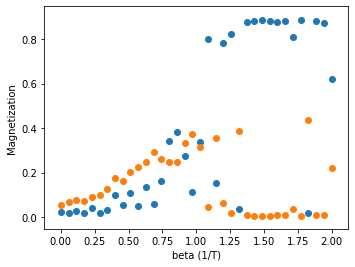

In [58]:
plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.scatter(tempe,abs(ma))
plt.scatter(tempe,msig*100)
plt.xlabel('beta (1/T)')
plt.ylabel('Magnetization')

plt.show()


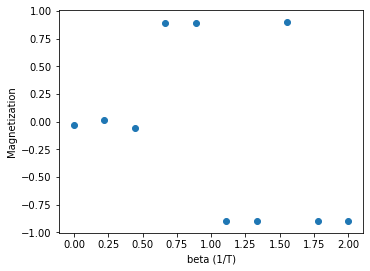

In [55]:
plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.scatter(tempe,(ma))
plt.xlabel('beta (1/T)')
plt.ylabel('Magnetization')

plt.show()



In [42]:
ss.rand(9,9,0.3).todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.70409826, 0.40041092, 0.69981097, 0.26080065],
        [0.        , 0.        , 0.        , 0.02418109, 0.03720777,
         0.04930293, 0.0057267 , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.25129404, 0.        , 0.1329011 , 0.86404999],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.35016773, 0.        , 0.        ],
        [0.        , 0.2240019 , 0.9907916 , 0.        , 0.        ,
         0.        , 0.        , 0.64764667, 0.        ],
        [0.        , 0.34621743, 0.        , 0.        , 0.        ,
         0.        , 0.04719338, 0.        , 0.90955116],
        [0.        , 0.        , 0.53809367, 0.        , 0.        ,
         0.57190898, 0.24763282, 0.        , 0.        ],
        [0.22086073, 0.        , 0.17651059, 0.        , 0.        ,
         0.        , 0.        , 0.       

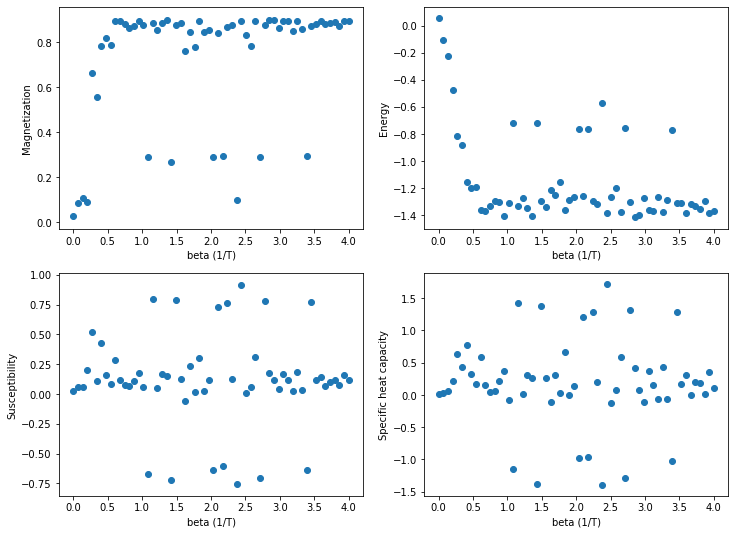

In [36]:
meas=20
dec=20
tmin=0
tmax=2
tn=60
t=0
ma=np.zeros(tn)
en=np.zeros(tn)
xi=np.zeros(tn)
cs=np.zeros(tn)
ma2=np.zeros(tn)
en2=np.zeros(tn)
m2=np.zeros(meas)
e2=np.zeros(meas)
mm=0
ee=0
A=AdD(3,3)[0]
N=AdD(3,3)[1]

tempe=np.linspace(tmin,tmax,tn)

for it in tempe:

    state=np.ones((meas,N))
    state[0]=initialstate(N,random=True)
    #state[0]=np.ones(N)
    e=np.zeros(meas)
    m=np.zeros(meas)
    m[0]=calcMag(state[0])

    for i in range(meas-1):       # misure
        for j in range(dec):      # decorrelazione
        #print(str(i)+": "+str(state))
            state[i+1]=mcmove(state[i], it, A).copy()
        m[i+1]=calcMag(state[i+1])
        e[i+1]=calcEnergy(state[i+1])
        m2[i+1]=m[i+1]*m[i+1]
        e2[i+1]=e[i+1]*e[i+1]
    m=m[meas//10:]
    ma[t]=sum(m)/meas
    ma2[t]=sum(m2)/meas
    en[t]=sum(e)/meas
    en2[t]=sum(e2)/meas
    xi[t]=ma2[t]-ma[t-1]**2
    cs[t]=en2[t]-en[t-1]**2
    
    t+=1



plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.scatter(tempe,abs(ma))
plt.xlabel('beta (1/T)')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.scatter(tempe,en)
#plt.ylim(-1,1)
plt.xlabel('beta (1/T)')
plt.ylabel('Energy')

plt.subplot(223)
plt.scatter(tempe,(xi))
plt.xlabel('beta (1/T)')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.scatter(tempe,(cs))
plt.xlabel('beta (1/T)')
plt.ylabel('Specific heat capacity')


plt.show()